In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.stats.multitest


# Введение
Датасет "Top Video Games 1995-2021 Metacritic" содержит информацию о самых рейтинговых видеоиграх 1995-2021 гг.

Импортируем его из https://www.kaggle.com/datasets/deepcontractor/top-video-games-19952021-metacritic

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("deepcontractor/top-video-games-19952021-metacritic")

print("Path to dataset files:", path)
path += '/all_games.csv'

Path to dataset files: /home/ttsypyshev/.cache/kagglehub/datasets/deepcontractor/top-video-games-19952021-metacritic/versions/4


Проверим данные на предмет присутствия пропусков, выбросов и пр. Также немного преобразуем данные для более эффективного хранения памяти и удобного использования в будущем.


In [4]:
df = pd.read_csv(path)

## Добавление user_review_count с случайными значениями

Делать необязательно (делаем только для расширения датасета)

In [5]:
# Добавление поля user_review_count с случайными значениями от 50 до 50000
df['user_review_count'] = np.random.randint(50, 50000, size=len(df))

# Сохранение DataFrame в CSV
# df.to_csv('all_games.csv', index=False)

print(df.columns)

Index(['name', 'platform', 'release_date', 'summary', 'meta_score',
       'user_review', 'user_review_count'],
      dtype='object')


## Валидация данных

In [6]:
# Проверка на пропуски
print("Пропуски до обработки:")
print(df.isna().sum())

Пропуски до обработки:
name                   0
platform               0
release_date           0
summary              114
meta_score             0
user_review            0
user_review_count      0
dtype: int64


In [7]:
# Заполнение пропусков
# df['summary'].fillna(df['summary'].mode()[0], inplace=True)

# Заполнение пропусков без inplace
df['summary'] = df['summary'].fillna(df['summary'].mode()[0])


In [8]:
# Проверка на пропуски после заполнения
print("Пропуски после обработки:")
print(df.isna().sum())

Пропуски после обработки:
name                 0
platform             0
release_date         0
summary              0
meta_score           0
user_review          0
user_review_count    0
dtype: int64


In [9]:
# Преобразование типов данных для оптимизации памяти
df['platform'] = df['platform'].astype('category')
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')

# Преобразование user_review из 10-балльной в 100-балльную систему
df['user_review'] = df['user_review'].apply(lambda x: float(x) * 10 if x != 'tbd' else None)
df['user_review'] = pd.to_numeric(df['user_review'], errors='coerce')  # Преобразуем в числовой тип


## Посчитаем основные статистики:

In [10]:
# Основные статистики
print("Основные статистики числовых признаков:")
print(df.describe())

Основные статистики числовых признаков:
                        release_date    meta_score  user_review  \
count                          18800  18800.000000  17435.00000   
mean   2011-10-03 21:18:36.765957376     70.648883     69.90846   
min              1995-04-30 00:00:00     20.000000      2.00000   
25%              2006-09-18 00:00:00     64.000000     63.00000   
50%              2011-10-18 00:00:00     72.000000     73.00000   
75%              2017-05-10 00:00:00     80.000000     79.00000   
max              2021-10-15 00:00:00     99.000000     97.00000   
std                              NaN     12.225006     13.51554   

       user_review_count  
count       18800.000000  
mean        25094.873883  
min            52.000000  
25%         12569.000000  
50%         25095.000000  
75%         37824.250000  
max         49997.000000  
std         14474.260089  


In [11]:
# Основные статистики для числовых признаков
print("Числовые данные:")
print(df[['meta_score', 'user_review']].describe())

Числовые данные:
         meta_score  user_review
count  18800.000000  17435.00000
mean      70.648883     69.90846
std       12.225006     13.51554
min       20.000000      2.00000
25%       64.000000     63.00000
50%       72.000000     73.00000
75%       80.000000     79.00000
max       99.000000     97.00000


In [12]:
# Основные статистики для категориальных признаков
print("Категориальные данные:")
print(df.select_dtypes('category').describe())

Категориальные данные:
       platform
count     18800
unique       22
top          PC
freq       4864


## Корреляционный анализ
Построим тепловую карту для изучения корреляции между числовыми признаками.

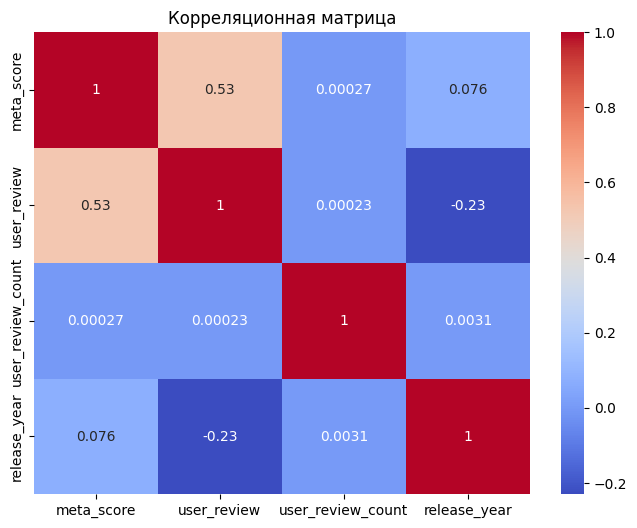

In [28]:
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Корреляционная матрица")
plt.show()

Заметим, что присутствут средняя кореляция между значением оценки критики и пользователей. Однако она не , на уровне >0.5, а значит мнение критиков и пользователей совподают не всегда, но зачастую

## Анализ распределения числовых данных

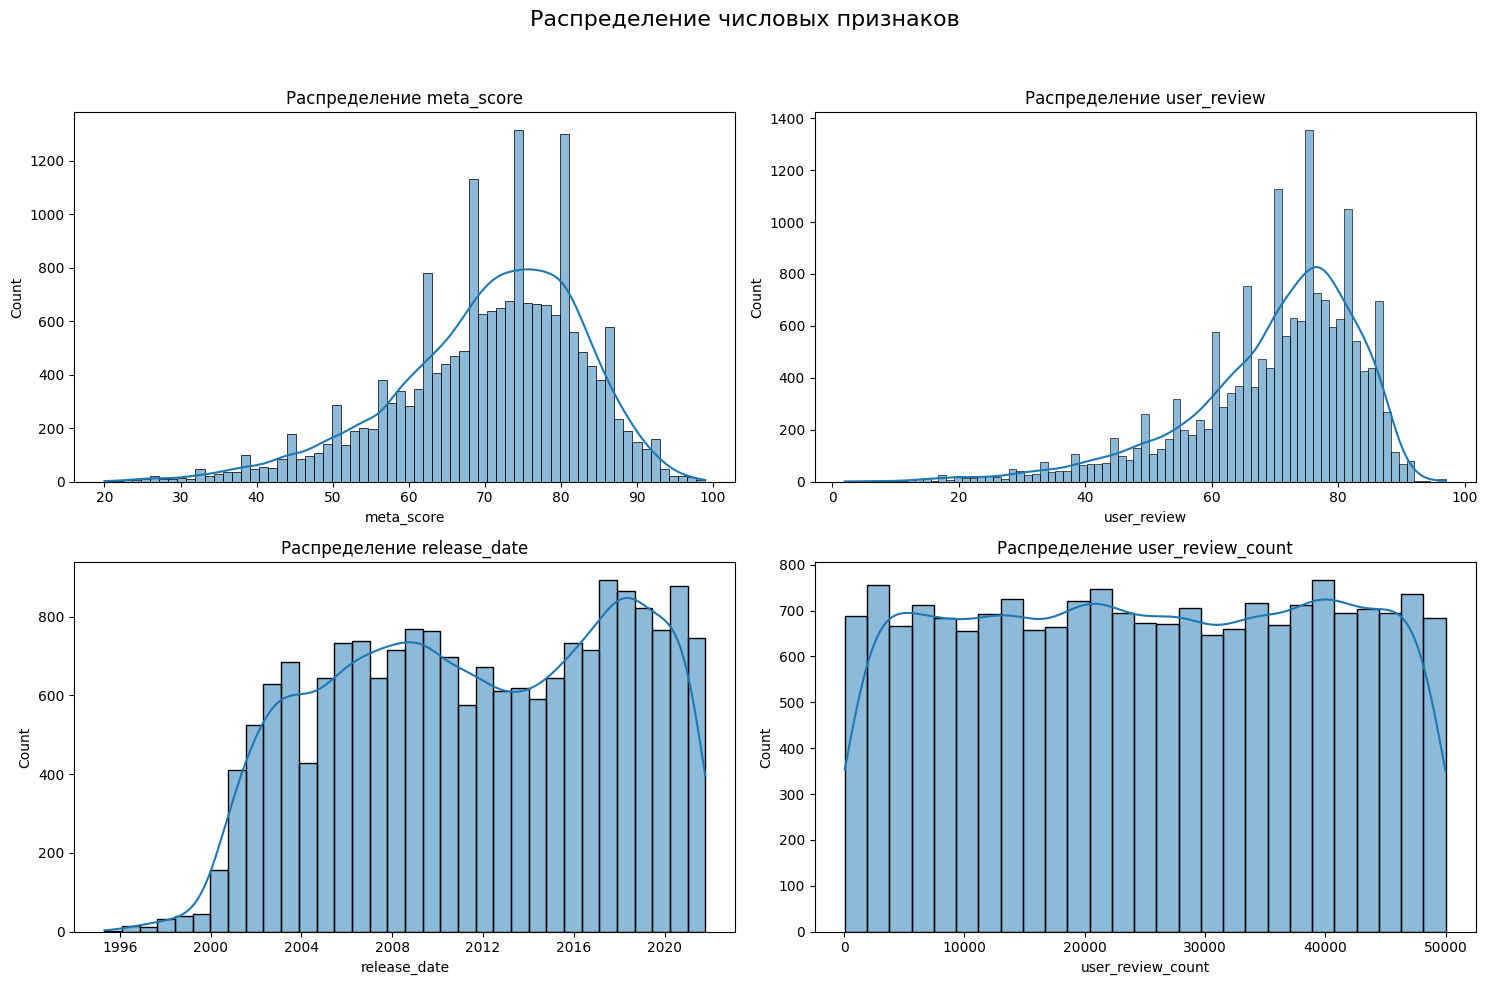

In [14]:
num_cols = ['meta_score', 'user_review', 'release_date', 'user_review_count']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))  # 2 строки и 2 столбца
fig.suptitle('Распределение числовых признаков', fontsize=16)

for idx, col in enumerate(num_cols):
    row = idx // 2
    col_idx = idx % 2
    sns.histplot(df[col], kde=True, ax=axes[row, col_idx])
    axes[row, col_idx].set_title(f"Распределение {col}")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


## Распределение категориальных данных

/tmp/ipykernel_5935/4142266415.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df['platform'], order=df['platform'].value_counts().index, palette="Set2")


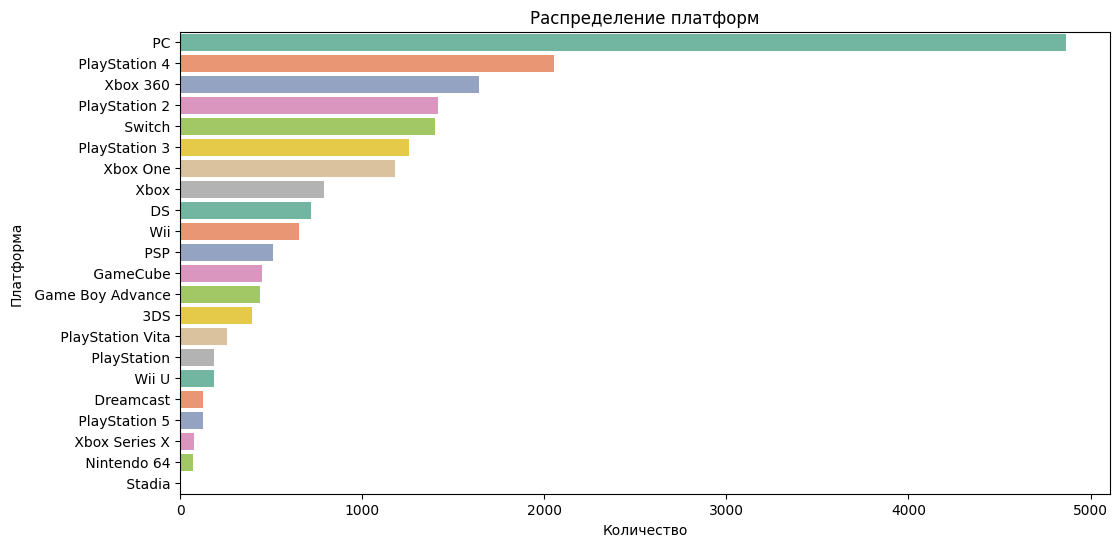

In [15]:
plt.figure(figsize=(12, 6))
sns.countplot(y=df['platform'], order=df['platform'].value_counts().index, palette="Set2")
plt.title("Распределение платформ")
plt.xlabel("Количество")
plt.ylabel("Платформа")
plt.show()

# Использование Boxplot и Violinplot для анализа распределений
Для непрерывных переменных можно использовать boxplot для идентификации выбросов и violinplot для демонстрации плотности вероятности:

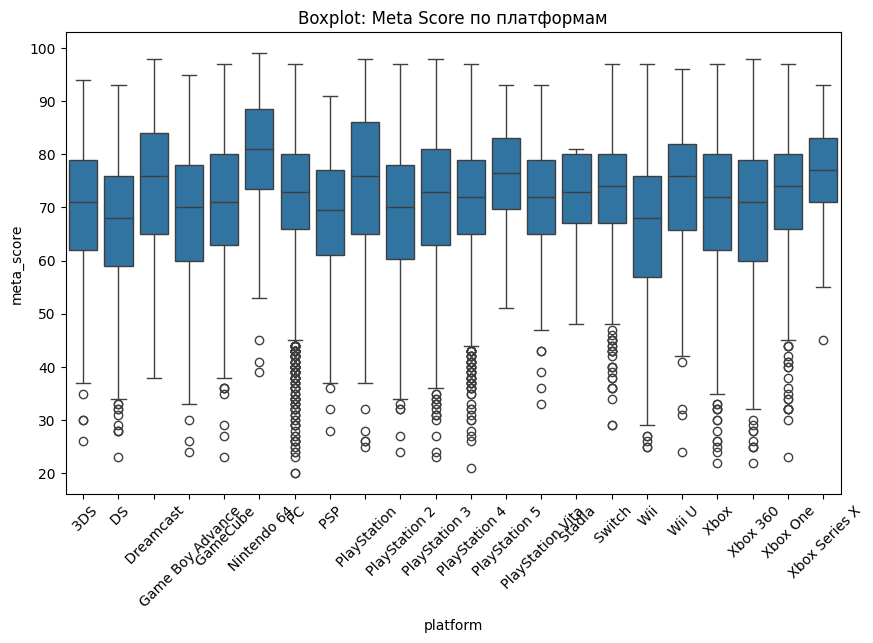

/tmp/ipykernel_5935/780149863.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='platform', y='user_review', inner='quart', palette='muted')


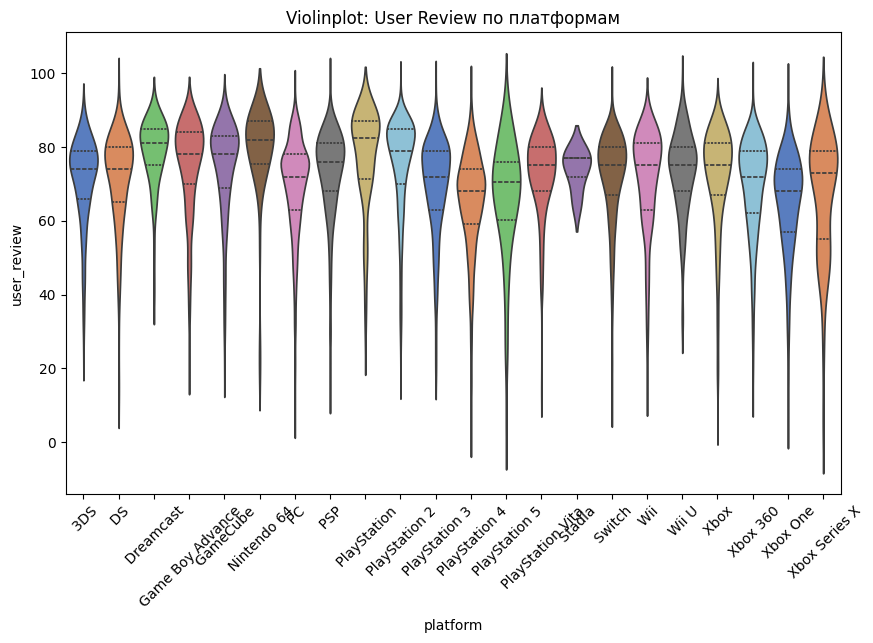

In [16]:
# Boxplot и Violinplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='platform', y='meta_score')
plt.title("Boxplot: Meta Score по платформам")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 6))
sns.violinplot(data=df, x='platform', y='user_review', inner='quart', palette='muted')
plt.title("Violinplot: User Review по платформам")
plt.xticks(rotation=45)
plt.show()

## Гипотезы для анализа
- Игры на разных платформах имеют разные средние оценки.
- Высокая оценка критиков коррелирует с высокой пользовательской оценкой.
- Год выпуска игры влияет на её популярность (по средним оценкам).
- Чем больше оценок от пользователей - тем нижи они в среднем
- Дата релиза имеет корреляцию с количеством отзывов пользователей

### Гипотеза 1: Разные средние оценки для разных платформ

/tmp/ipykernel_5935/986611645.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='meta_score', y='platform', data=df, palette="Set3")


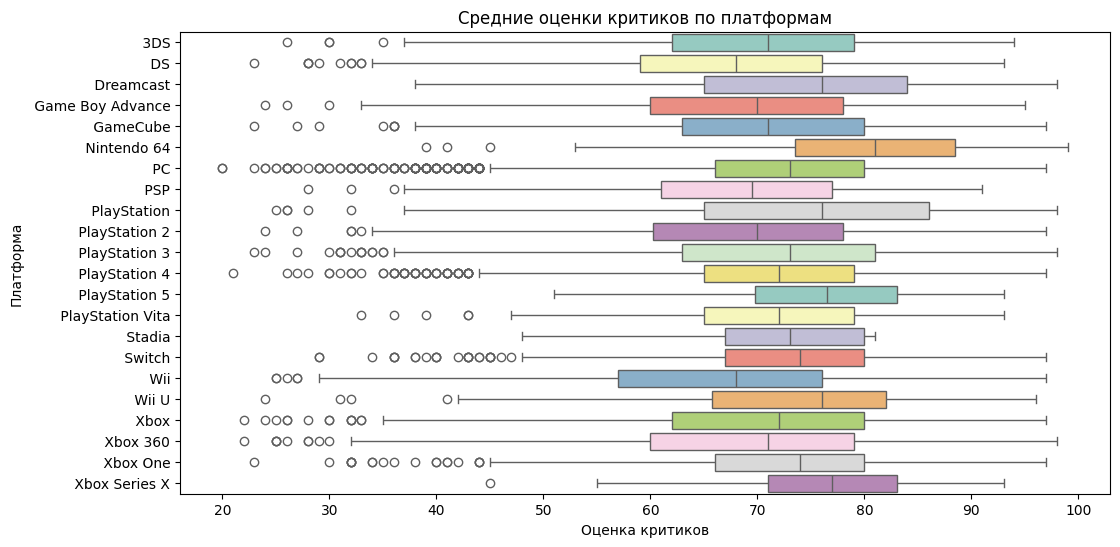

In [17]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='meta_score', y='platform', data=df, palette="Set3")
plt.title("Средние оценки критиков по платформам")
plt.xlabel("Оценка критиков")
plt.ylabel("Платформа")
plt.show()

In [18]:
# ANOVA-тест для проверки гипотезы
platform_groups = [df['meta_score'][df['platform'] == platform] for platform in df['platform'].unique()]
f_stat, p_val = stats.f_oneway(*platform_groups)
print(f"F-statistic: {f_stat}, P-value: {p_val}")
if p_val < 0.05:
    print("Средние оценки различаются для разных платформ.")
else:
    print("Нет статистически значимых различий между средними оценками платформ.")

F-statistic: 22.46751523538599, P-value: 1.6461121887183078e-85
Средние оценки различаются для разных платформ.


### Гипотеза 2: Корреляция между оценками критиков и пользователей

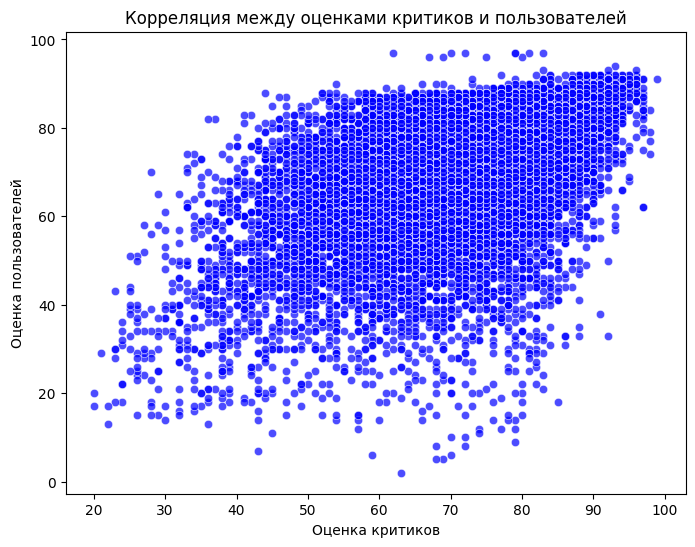

In [19]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='meta_score', y='user_review', data=df, alpha=0.7, color='blue')
plt.title("Корреляция между оценками критиков и пользователей")
plt.xlabel("Оценка критиков")
plt.ylabel("Оценка пользователей")
plt.show()

In [20]:
# Корреляция Пирсона
correlation, p_val = stats.pearsonr(df['meta_score'], df['user_review'])
print(f"Корреляция: {correlation}, P-value: {p_val}")
if p_val < 0.05:
    print("Корреляция статистически значима.")
else:
    print("Корреляция не является статистически значимой.")

Корреляция: nan, P-value: nan
Корреляция не является статистически значимой.


### Гипотеза 3: Влияние года выпуска на оценки

In [21]:
# Извлечение года из даты релиза
df['release_year'] = df['release_date'].dt.year

In [22]:
# Средние оценки по годам
avg_scores_by_year = df.groupby('release_year')[['meta_score', 'user_review']].mean()

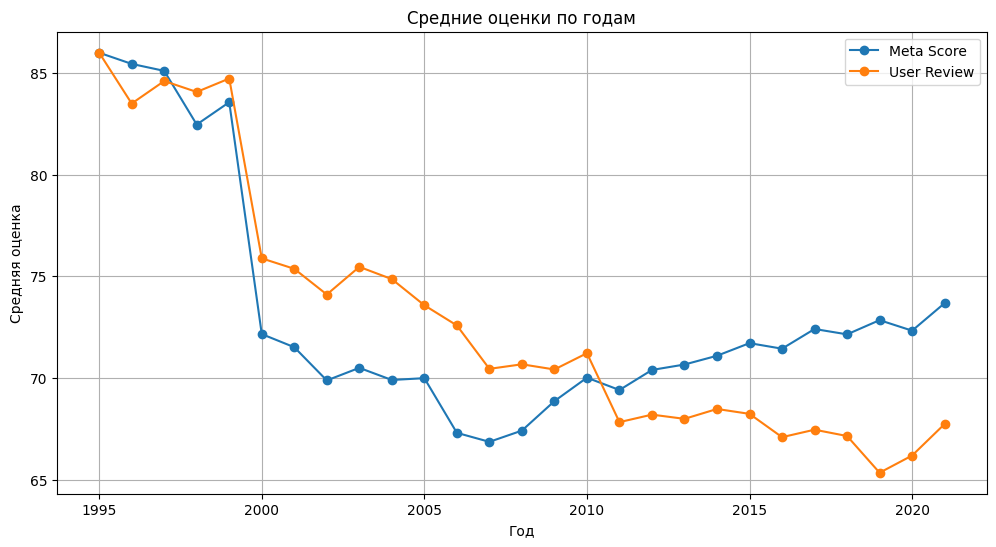

In [23]:
plt.figure(figsize=(12, 6))
plt.plot(avg_scores_by_year.index, avg_scores_by_year['meta_score'], label='Meta Score', marker='o')
plt.plot(avg_scores_by_year.index, avg_scores_by_year['user_review'], label='User Review', marker='o')
plt.title("Средние оценки по годам")
plt.xlabel("Год")
plt.ylabel("Средняя оценка")
plt.legend()
plt.grid()
plt.show()

### Гипотеза 4: Чем больше оценок от пользователей — тем ниже они в среднем

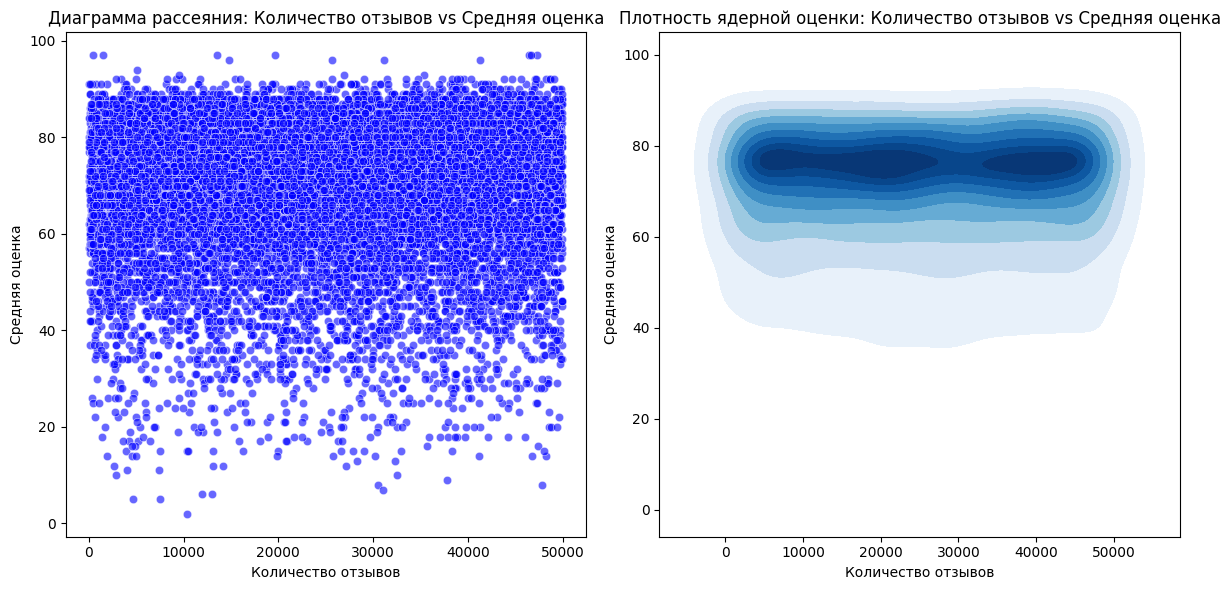

In [24]:
plt.figure(figsize=(12, 6))

# Scatter plot
plt.subplot(1, 2, 1)
sns.scatterplot(data=df, x='user_review_count', y='user_review', color='blue', alpha=0.6)
plt.title('Диаграмма рассеяния: Количество отзывов vs Средняя оценка')
plt.xlabel('Количество отзывов')
plt.ylabel('Средняя оценка')

# KDE plot
plt.subplot(1, 2, 2)
sns.kdeplot(data=df, x='user_review_count', y='user_review', cmap='Blues', fill=True)
plt.title('Плотность ядерной оценки: Количество отзывов vs Средняя оценка')
plt.xlabel('Количество отзывов')
plt.ylabel('Средняя оценка')

plt.tight_layout()
plt.show()

In [25]:
correlation = df[['user_review_count', 'user_review']].corr()
print("Результаты корреляционного анализа для гипотезы 1:")
print(correlation)

if correlation.loc['user_review_count', 'user_review'] < 0:
    print("Гипотеза 4 подтверждается: Чем больше отзывов, тем ниже средняя оценка.")
else:
    print("Гипотеза 4 не подтверждается: Нет отрицательной корреляции между количеством отзывов и средней оценкой.")

Результаты корреляционного анализа для гипотезы 1:
                   user_review_count  user_review
user_review_count           1.000000     0.000228
user_review                 0.000228     1.000000
Гипотеза 4 не подтверждается: Нет отрицательной корреляции между количеством отзывов и средней оценкой.


### Гипотеза 5: Дата релиза имеет корреляцию с количеством отзывов пользователей

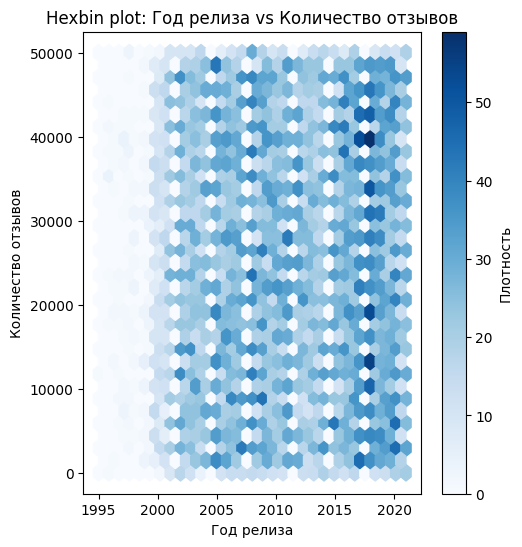

In [26]:
df['release_year'] = df['release_date'].dt.year  # извлечем год из даты релиза

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hexbin(df['release_year'], df['user_review_count'], gridsize=30, cmap='Blues')
plt.title('Hexbin plot: Год релиза vs Количество отзывов')
plt.xlabel('Год релиза')
plt.ylabel('Количество отзывов')
plt.colorbar(label='Плотность')

plt.show()

In [27]:
correlation_release = df[['release_year', 'user_review_count']].corr()
print("Корреляция между годом релиза и количеством отзывов:")
print(correlation_release)

if correlation_release.loc['release_year', 'user_review_count'] > 0:
    print("Гипотеза 5 подтверждается: существует положительная корреляция между годом релиза и количеством отзывов.")
else:
    print("Гипотеза 5 не подтверждается: нет значимой корреляции между годом релиза и количеством отзывов.")

Корреляция между годом релиза и количеством отзывов:
                   release_year  user_review_count
release_year           1.000000           0.003144
user_review_count      0.003144           1.000000
Гипотеза 5 подтверждается: существует положительная корреляция между годом релиза и количеством отзывов.
